## MobileNetV2 Transfer Learning for Eye Drowsiness Detection

Dataset: https://www.kaggle.com/datasets/prasadvpatil/mrl-dataset/versions/3

In [1]:
import kagglehub
import os
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit, GroupKFold

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

DATASET_PATH = kagglehub.dataset_download("prasadvpatil/mrl-dataset/versions/3")
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
print("Path to dataset files:", DATASET_PATH)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

BATCH_SIZE = 32
LEARNING_RATE = 1e-5  
WEIGHT_DECAY = 1e-3   
EPOCHS = 30           
IMG_SIZE = 224
TEST_SPLIT = 0.15
N_FOLDS = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

c:\Users\GN\anaconda3\envs\computer_vision\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\GN\.cache\kagglehub\datasets\prasadvpatil\mrl-dataset\versions\3
Using device: cuda


In [2]:
class EyeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [3]:
classes = sorted(os.listdir(TRAIN_DIR)) 
all_image_paths = []
all_labels = []
all_subject_ids = []

for label_idx, label in enumerate(classes):
    class_dir = os.path.join(TRAIN_DIR, label)
    for img_file in os.listdir(class_dir):
        if img_file.lower().endswith((".png", ".jpg", ".jpeg")):
            full_path = os.path.join(class_dir, img_file)
            all_image_paths.append(full_path)
            all_labels.append(label_idx)
            
            filename = os.path.basename(img_file)
            subject_id = filename.split('_')[0] 
            all_subject_ids.append(subject_id)

df = pd.DataFrame({
    'path': all_image_paths,
    'label': all_labels,
    'subject_id': all_subject_ids
})

splitter_test = GroupShuffleSplit(test_size=TEST_SPLIT, n_splits=1, random_state=42)
trainval_idxs, test_idxs = next(splitter_test.split(df, groups=df['subject_id']))

trainval_df = df.iloc[trainval_idxs]
test_df = df.iloc[test_idxs]

test_paths = test_df['path'].tolist()
test_labels = test_df['label'].tolist()

print(f"Total Subjects: {df['subject_id'].nunique()}")
print(f"TrainVal Subjects: {trainval_df['subject_id'].nunique()}")
print(f"Test Subjects:     {test_df['subject_id'].nunique()}")
print(f"TrainVal images:   {len(trainval_df)}")
print(f"Test images:       {len(test_df)}")

Total Subjects: 19
TrainVal Subjects: 16
Test Subjects:     3
TrainVal images:   7275
Test images:       2725


## Data Splitting

In [4]:
trainval_subjects = set(trainval_df['subject_id'])
test_subjects = set(test_df['subject_id'])

overlap = trainval_subjects.intersection(test_subjects)
print(f"Overlap between TrainVal and Test: {len(overlap)}")

Overlap between TrainVal and Test: 0


In [5]:
group_kfold_check = GroupKFold(n_splits=N_FOLDS)
for fold, (train_idx, val_idx) in enumerate(group_kfold_check.split(trainval_df, groups=trainval_df['subject_id']), 1):
    train_subjects = set(trainval_df.iloc[train_idx]['subject_id'])
    val_subjects = set(trainval_df.iloc[val_idx]['subject_id'])
    overlap = train_subjects.intersection(val_subjects)
    print(f"Fold {fold} - Train subjects: {len(train_subjects)}, Val subjects: {len(val_subjects)}, Overlap: {len(overlap)}")

Fold 1 - Train subjects: 15, Val subjects: 1, Overlap: 0
Fold 2 - Train subjects: 14, Val subjects: 2, Overlap: 0
Fold 3 - Train subjects: 12, Val subjects: 4, Overlap: 0
Fold 4 - Train subjects: 12, Val subjects: 4, Overlap: 0
Fold 5 - Train subjects: 11, Val subjects: 5, Overlap: 0


In [6]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
test_dataset = EyeDataset(test_paths, test_labels, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## MobileNetV2 Transfer Learning Model

In [8]:
def create_mobilenet_model(pretrained=True, num_classes=2, dropout=0.5):
    model = models.mobilenet_v2(weights='IMAGENET1K_V1' if pretrained else None)
    
    for param in model.features[:-3].parameters():
        param.requires_grad = False
    
    in_features = model.classifier[1].in_features
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(in_features, 128),  
        nn.BatchNorm1d(128),  
        nn.ReLU(),
        nn.Dropout(p=0.4),  
        nn.Linear(128, num_classes)
    )
    
    return model

sample_model = create_mobilenet_model()
print("MobileNetV2 model architecture:")
print(sample_model)
total_params = sum(p.numel() for p in sample_model.parameters())
trainable_params = sum(p.numel() for p in sample_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

MobileNetV2 model architecture:
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

## 5-Fold Cross-Validation Training

Starting 5-Fold Cross-Validation with MobileNetV2...

FOLD 1/5
Train subjects: 15, images: 5659
Val subjects:   1, images: 1616
Epoch 1/30 | Train Loss: 0.4726, Acc: 0.7632 | Val Loss: 0.5809, Acc: 0.7990
Epoch 2/30 | Train Loss: 0.1483, Acc: 0.9737 | Val Loss: 0.3555, Acc: 0.9583
Epoch 3/30 | Train Loss: 0.0793, Acc: 0.9935 | Val Loss: 0.3016, Acc: 0.9645
Epoch 4/30 | Train Loss: 0.0609, Acc: 0.9958 | Val Loss: 0.2579, Acc: 0.9645
Epoch 5/30 | Train Loss: 0.0509, Acc: 0.9972 | Val Loss: 0.2618, Acc: 0.9393
Epoch 6/30 | Train Loss: 0.0445, Acc: 0.9986 | Val Loss: 0.2100, Acc: 0.9730
Epoch 7/30 | Train Loss: 0.0430, Acc: 0.9970 | Val Loss: 0.3278, Acc: 0.8958
Epoch 8/30 | Train Loss: 0.0399, Acc: 0.9977 | Val Loss: 0.2077, Acc: 0.9743
Epoch 9/30 | Train Loss: 0.0405, Acc: 0.9979 | Val Loss: 0.2385, Acc: 0.9577
Epoch 10/30 | Train Loss: 0.0429, Acc: 0.9984 | Val Loss: 0.2030, Acc: 0.9718
Epoch 11/30 | Train Loss: 0.0368, Acc: 0.9972 | Val Loss: 0.1274, Acc: 0.9890
Epoch 12/30 | Train Los

C:\Users\GN\AppData\Local\Temp\ipykernel_15836\3014876736.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"outputs/mobilenet_2/fold_{

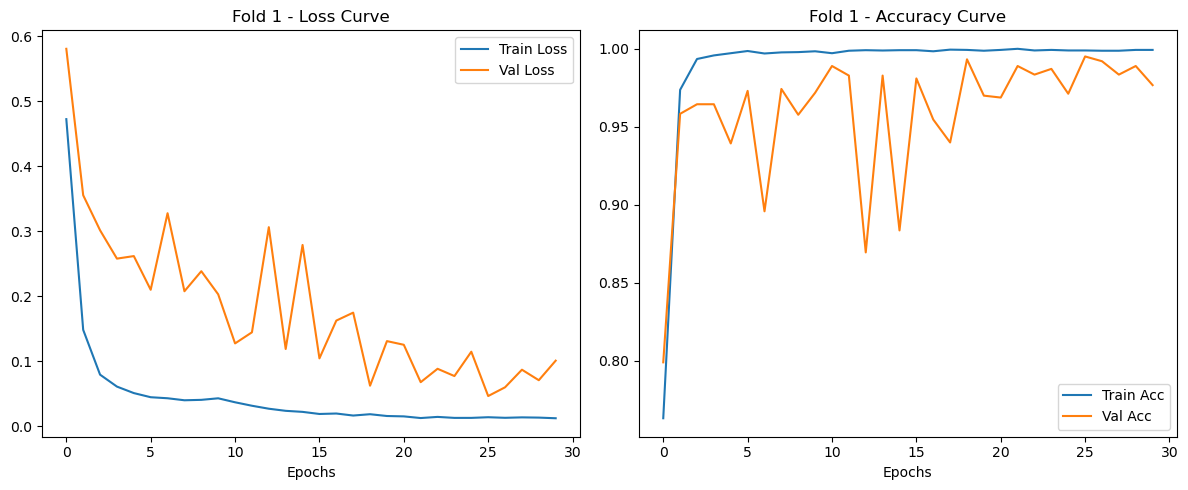

Fold 1 Best Val Accuracy: 0.9951

FOLD 2/5
Train subjects: 14, images: 5828
Val subjects:   2, images: 1447
Epoch 1/30 | Train Loss: 0.5462, Acc: 0.6996 | Val Loss: 0.1196, Acc: 0.9844
Epoch 2/30 | Train Loss: 0.1788, Acc: 0.9793 | Val Loss: 0.0936, Acc: 0.9742
Epoch 3/30 | Train Loss: 0.1028, Acc: 0.9968 | Val Loss: 0.1019, Acc: 0.9742
Epoch 4/30 | Train Loss: 0.0907, Acc: 0.9927 | Val Loss: 0.0794, Acc: 0.9823
Epoch 5/30 | Train Loss: 0.0727, Acc: 0.9980 | Val Loss: 0.0658, Acc: 0.9891
Epoch 6/30 | Train Loss: 0.0713, Acc: 0.9971 | Val Loss: 0.0681, Acc: 0.9905
Epoch 7/30 | Train Loss: 0.0652, Acc: 0.9973 | Val Loss: 0.0706, Acc: 0.9885
Epoch 8/30 | Train Loss: 0.0593, Acc: 0.9985 | Val Loss: 0.0877, Acc: 0.9789
Epoch 9/30 | Train Loss: 0.0575, Acc: 0.9986 | Val Loss: 0.0664, Acc: 0.9885
Epoch 10/30 | Train Loss: 0.0626, Acc: 0.9952 | Val Loss: 0.0583, Acc: 0.9918
Epoch 11/30 | Train Loss: 0.0566, Acc: 0.9976 | Val Loss: 0.0791, Acc: 0.9817
Epoch 12/30 | Train Loss: 0.0480, Acc: 0.99

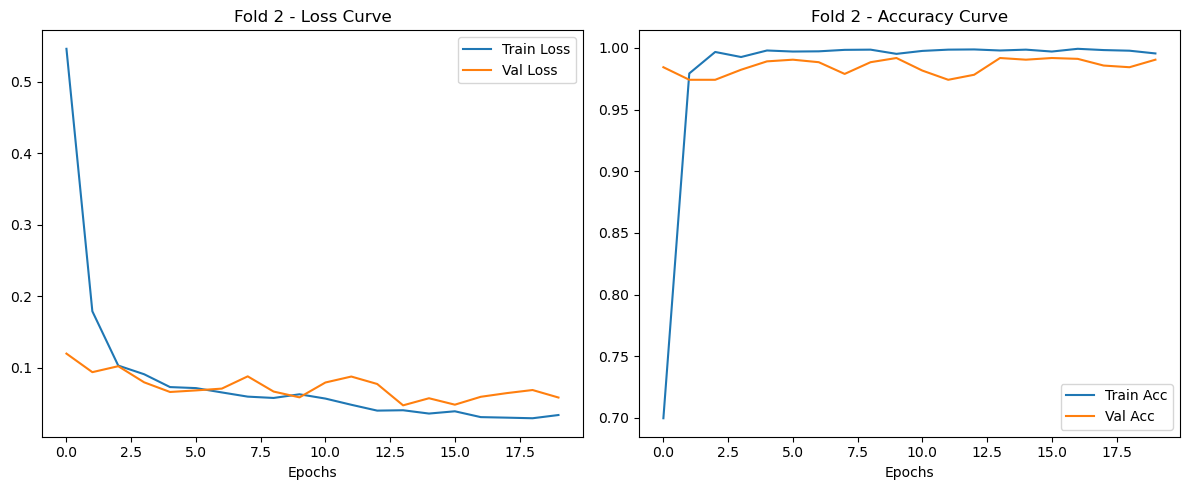

Fold 2 Best Val Accuracy: 0.9918

FOLD 3/5
Train subjects: 12, images: 5859
Val subjects:   4, images: 1416
Epoch 1/30 | Train Loss: 0.4241, Acc: 0.8188 | Val Loss: 0.9049, Acc: 0.3403
Epoch 2/30 | Train Loss: 0.1195, Acc: 0.9869 | Val Loss: 0.8471, Acc: 0.4632
Epoch 3/30 | Train Loss: 0.0674, Acc: 0.9958 | Val Loss: 0.7403, Acc: 0.5257
Epoch 4/30 | Train Loss: 0.0616, Acc: 0.9926 | Val Loss: 0.6079, Acc: 0.6194
Epoch 5/30 | Train Loss: 0.0444, Acc: 0.9985 | Val Loss: 0.5633, Acc: 0.6542
Epoch 6/30 | Train Loss: 0.0416, Acc: 0.9978 | Val Loss: 0.6150, Acc: 0.6236
Epoch 7/30 | Train Loss: 0.0372, Acc: 0.9988 | Val Loss: 0.6321, Acc: 0.6076
Epoch 8/30 | Train Loss: 0.0357, Acc: 0.9986 | Val Loss: 0.7909, Acc: 0.5299
Epoch 9/30 | Train Loss: 0.0362, Acc: 0.9975 | Val Loss: 0.6518, Acc: 0.6069
Epoch 10/30 | Train Loss: 0.0347, Acc: 0.9983 | Val Loss: 0.5134, Acc: 0.6882
Epoch 11/30 | Train Loss: 0.0308, Acc: 0.9981 | Val Loss: 0.8332, Acc: 0.5299
Epoch 12/30 | Train Loss: 0.0281, Acc: 0.99

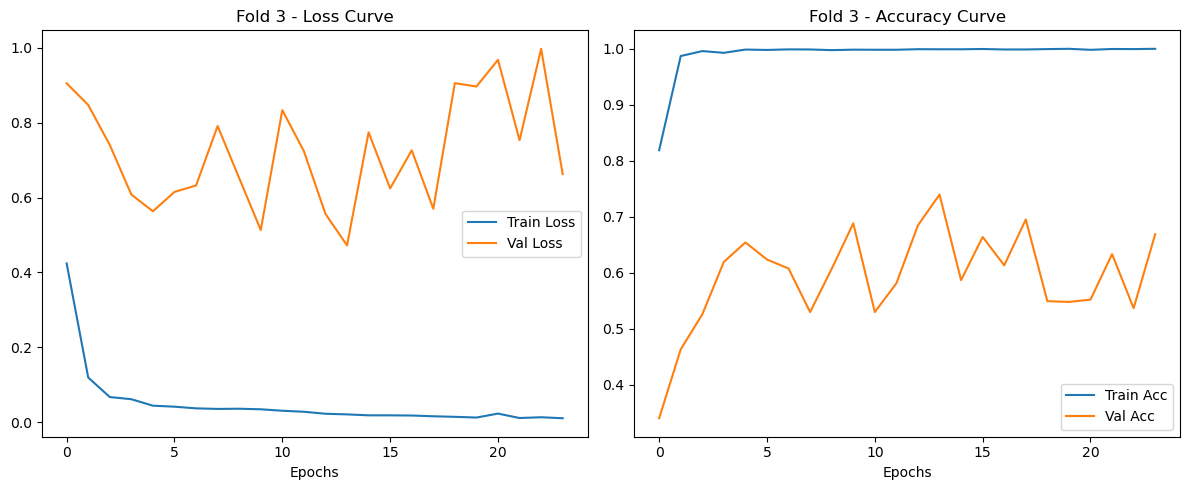

Fold 3 Best Val Accuracy: 0.7396

FOLD 4/5
Train subjects: 12, images: 5856
Val subjects:   4, images: 1419
Epoch 1/30 | Train Loss: 0.4482, Acc: 0.8017 | Val Loss: 0.1890, Acc: 0.9924
Epoch 2/30 | Train Loss: 0.1367, Acc: 0.9845 | Val Loss: 0.0870, Acc: 0.9951
Epoch 3/30 | Train Loss: 0.0798, Acc: 0.9949 | Val Loss: 0.0722, Acc: 0.9951
Epoch 4/30 | Train Loss: 0.0641, Acc: 0.9961 | Val Loss: 0.0614, Acc: 0.9938
Epoch 5/30 | Train Loss: 0.0558, Acc: 0.9961 | Val Loss: 0.0589, Acc: 0.9931
Epoch 6/30 | Train Loss: 0.0488, Acc: 0.9980 | Val Loss: 0.0554, Acc: 0.9938
Epoch 7/30 | Train Loss: 0.0440, Acc: 0.9985 | Val Loss: 0.0681, Acc: 0.9896
Epoch 8/30 | Train Loss: 0.0431, Acc: 0.9973 | Val Loss: 0.0518, Acc: 0.9938
Epoch 9/30 | Train Loss: 0.0422, Acc: 0.9973 | Val Loss: 0.0580, Acc: 0.9910
Epoch 10/30 | Train Loss: 0.0429, Acc: 0.9981 | Val Loss: 0.0611, Acc: 0.9910
Epoch 11/30 | Train Loss: 0.0383, Acc: 0.9985 | Val Loss: 0.0460, Acc: 0.9938
Epoch 12/30 | Train Loss: 0.0337, Acc: 0.99

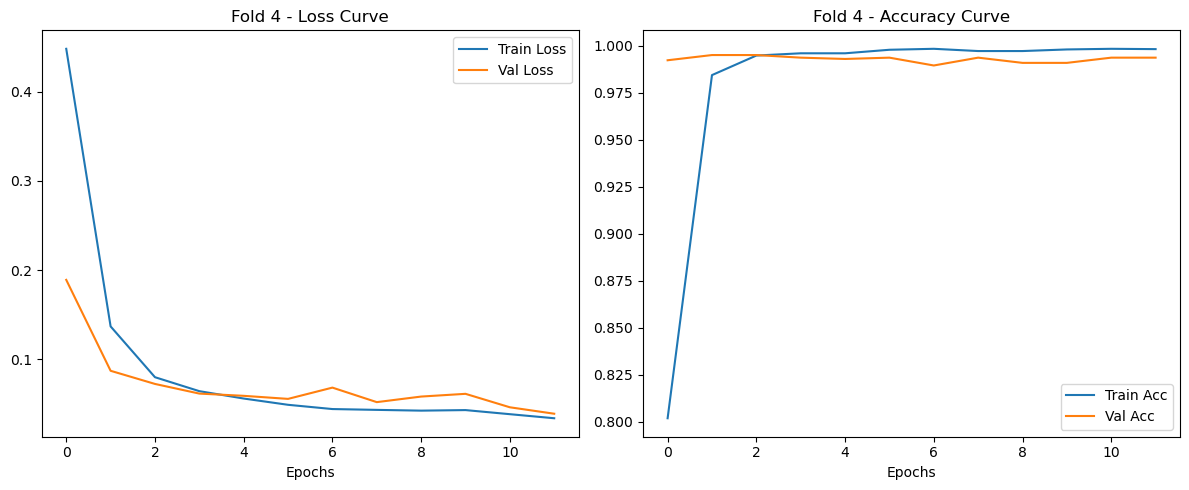

Fold 4 Best Val Accuracy: 0.9951

FOLD 5/5
Train subjects: 11, images: 5898
Val subjects:   5, images: 1377
Epoch 1/30 | Train Loss: 0.4338, Acc: 0.8169 | Val Loss: 0.3456, Acc: 0.9091
Epoch 2/30 | Train Loss: 0.1170, Acc: 0.9894 | Val Loss: 0.1693, Acc: 0.9915
Epoch 3/30 | Train Loss: 0.0661, Acc: 0.9956 | Val Loss: 0.1260, Acc: 0.9922
Epoch 4/30 | Train Loss: 0.0524, Acc: 0.9975 | Val Loss: 0.1010, Acc: 0.9929
Epoch 5/30 | Train Loss: 0.0431, Acc: 0.9981 | Val Loss: 0.0878, Acc: 0.9936
Epoch 6/30 | Train Loss: 0.0411, Acc: 0.9978 | Val Loss: 0.0830, Acc: 0.9893
Epoch 7/30 | Train Loss: 0.0371, Acc: 0.9988 | Val Loss: 0.0752, Acc: 0.9964
Epoch 8/30 | Train Loss: 0.0365, Acc: 0.9973 | Val Loss: 0.0772, Acc: 0.9929
Epoch 9/30 | Train Loss: 0.0348, Acc: 0.9990 | Val Loss: 0.0764, Acc: 0.9929
Epoch 10/30 | Train Loss: 0.0359, Acc: 0.9985 | Val Loss: 0.0694, Acc: 0.9957
Epoch 11/30 | Train Loss: 0.0308, Acc: 0.9985 | Val Loss: 0.0655, Acc: 0.9936
Epoch 12/30 | Train Loss: 0.0286, Acc: 0.99

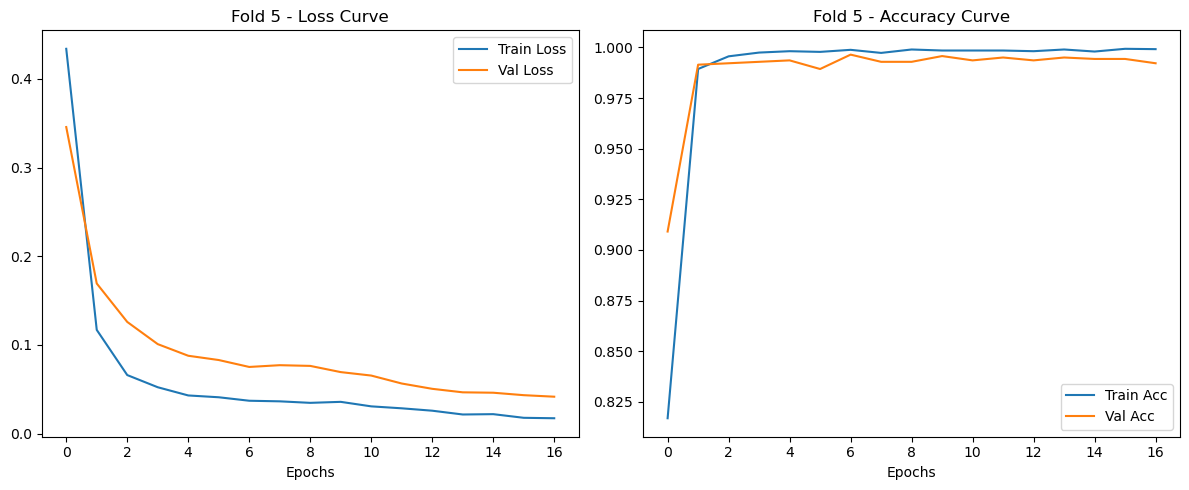

Fold 5 Best Val Accuracy: 0.9964


K-FOLD CROSS-VALIDATION SUMMARY
Fold 1: Best Val Acc = 0.9951
Fold 2: Best Val Acc = 0.9918
Fold 3: Best Val Acc = 0.7396
Fold 4: Best Val Acc = 0.9951
Fold 5: Best Val Acc = 0.9964

Mean Val Accuracy: 0.9436 ± 0.1020
Best Fold: 5 with Val Acc: 0.9964


In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

os.makedirs("../outputs/mobilenet", exist_ok=True)

def accuracy(preds, labels):
    return (preds.argmax(dim=1) == labels).float().mean().item()

group_kfold = GroupKFold(n_splits=N_FOLDS)
fold_results = []
all_fold_histories = []

print(f"Starting {N_FOLDS}-Fold Cross-Validation with MobileNetV2...\n")

for fold, (train_idx, val_idx) in enumerate(group_kfold.split(trainval_df, groups=trainval_df['subject_id']), 1):
    print(f"{'='*60}")
    print(f"FOLD {fold}/{N_FOLDS}")
    print(f"{'='*60}")
    
    train_fold_df = trainval_df.iloc[train_idx]
    val_fold_df = trainval_df.iloc[val_idx]
    
    print(f"Train subjects: {train_fold_df['subject_id'].nunique()}, images: {len(train_fold_df)}")
    print(f"Val subjects:   {val_fold_df['subject_id'].nunique()}, images: {len(val_fold_df)}")
    
    train_dataset = EyeDataset(train_fold_df['path'].tolist(), train_fold_df['label'].tolist(), transform=train_transform)
    val_dataset = EyeDataset(val_fold_df['path'].tolist(), val_fold_df['label'].tolist(), transform=val_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    model = create_mobilenet_model(pretrained=True, num_classes=2, dropout=0.5).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=LEARNING_RATE, 
        weight_decay=WEIGHT_DECAY
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-7
    )
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_acc = 0.0
    early_stopping_patience = 10
    epochs_no_improve = 0
    
    for epoch in range(EPOCHS):
        model.train()
        total_loss, total_acc = 0, 0
        
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            total_acc += accuracy(outputs, lbls)
        
        avg_train_loss = total_loss / len(train_loader)
        avg_train_acc = total_acc / len(train_loader)
        
        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        
        model.eval()
        val_loss_sum, val_acc_sum = 0, 0
        
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, lbls)
                
                val_loss_sum += loss.item()
                val_acc_sum += accuracy(outputs, lbls)
        
        avg_val_loss = val_loss_sum / len(val_loader)
        avg_val_acc = val_acc_sum / len(val_loader)
        
        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)
        
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")
        
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            torch.save(model.state_dict(), f"../outputs/mobilenet/fold_{fold}_best_model.pth")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(torch.load(f"../outputs/mobilenet/fold_{fold}_best_model.pth"))
    
    fold_results.append({
        'fold': fold,
        'best_val_acc': best_val_acc,
        'final_train_acc': train_accs[-1],
        'final_val_acc': val_accs[-1]
    })
    
    all_fold_histories.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    })
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title(f"Fold {fold} - Loss Curve")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.title(f"Fold {fold} - Accuracy Curve")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"../outputs/mobilenet/fold_{fold}_training_curves.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Fold {fold} Best Val Accuracy: {best_val_acc:.4f}\n")

print(f"\n{'='*60}")
print("K-FOLD CROSS-VALIDATION SUMMARY")
print(f"{'='*60}")
for result in fold_results:
    print(f"Fold {result['fold']}: Best Val Acc = {result['best_val_acc']:.4f}")

mean_val_acc = np.mean([r['best_val_acc'] for r in fold_results])
std_val_acc = np.std([r['best_val_acc'] for r in fold_results])
print(f"\nMean Val Accuracy: {mean_val_acc:.4f} ± {std_val_acc:.4f}")

best_fold_idx = np.argmax([r['best_val_acc'] for r in fold_results])
best_fold = fold_results[best_fold_idx]['fold']
print(f"Best Fold: {best_fold} with Val Acc: {fold_results[best_fold_idx]['best_val_acc']:.4f}")


K-FOLD CROSS-VALIDATION SUMMARY

Detailed Results by Fold:
 fold  best_val_acc  final_train_acc  final_val_acc  final_train_loss  final_val_loss
    1      0.995098         0.999294       0.976716          0.012176        0.100851
    2      0.991848         0.995560       0.990489          0.033602        0.058093
    3      0.739583         0.999830       0.668750          0.010797        0.662378
    4      0.995139         0.998292       0.993750          0.033705        0.038782
    5      0.996449         0.999155       0.992188          0.017407        0.041700

STATISTICAL SUMMARY
Train Accuracy      : 0.9984 ± 0.0017 (min: 0.9956, max: 0.9998)
Val Accuracy        : 0.9436 ± 0.1141 (min: 0.7396, max: 0.9964)
Train Loss          : 0.0215 ± 0.0113 (min: 0.0108, max: 0.0337)
Val Loss            : 0.1804 ± 0.2706 (min: 0.0388, max: 0.6624)

Best Fold: 5 with Val Acc: 0.9964


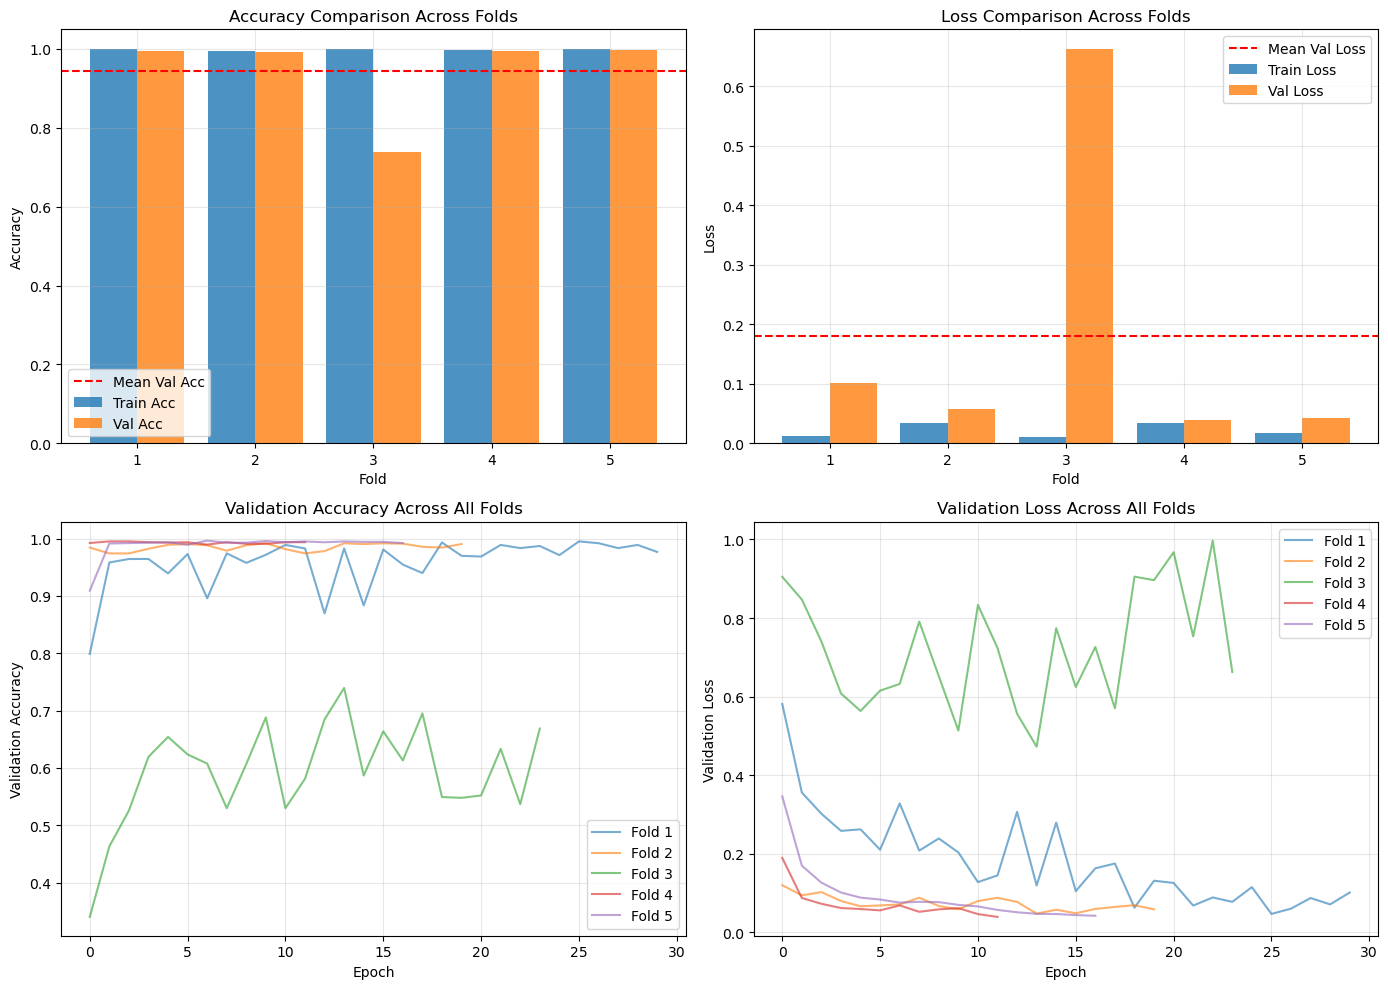


Loading best model from Fold 5 for final test evaluation...


C:\Users\GN\AppData\Local\Temp\ipykernel_15836\1862762586.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load(f"outputs/mobilenet_2/f

<All keys matched successfully>

In [ ]:
print(f"\n{'='*60}")
print("K-FOLD CROSS-VALIDATION SUMMARY")
print(f"{'='*60}")

results_df = pd.DataFrame(fold_results)

for i, history in enumerate(all_fold_histories):
    results_df.loc[i, 'final_train_loss'] = history['train_losses'][-1]
    results_df.loc[i, 'final_val_loss'] = history['val_losses'][-1]

print("\nDetailed Results by Fold:")
print(results_df.to_string(index=False))

print(f"\n{'='*60}")
print("STATISTICAL SUMMARY")
print(f"{'='*60}")

metrics = {
    'Train Accuracy': results_df['final_train_acc'],
    'Val Accuracy': results_df['best_val_acc'],
    'Train Loss': results_df['final_train_loss'],
    'Val Loss': results_df['final_val_loss']
}

for metric_name, values in metrics.items():
    mean = values.mean()
    std = values.std()
    min_val = values.min()
    max_val = values.max()
    print(f"{metric_name:20s}: {mean:.4f} ± {std:.4f} (min: {min_val:.4f}, max: {max_val:.4f})")

print(f"\n{'='*60}")
print(f"Best Fold: {best_fold} with Val Acc: {fold_results[best_fold_idx]['best_val_acc']:.4f}")
print(f"{'='*60}")

results_df.to_csv("../outputs/mobilenet/kfold_results_summary.csv", index=False)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].bar(results_df['fold'] - 0.2, results_df['final_train_acc'], 0.4, label='Train Acc', alpha=0.8)
axes[0, 0].bar(results_df['fold'] + 0.2, results_df['best_val_acc'], 0.4, label='Val Acc', alpha=0.8)
axes[0, 0].axhline(y=results_df['best_val_acc'].mean(), color='r', linestyle='--', label='Mean Val Acc')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy Comparison Across Folds')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].bar(results_df['fold'] - 0.2, results_df['final_train_loss'], 0.4, label='Train Loss', alpha=0.8)
axes[0, 1].bar(results_df['fold'] + 0.2, results_df['final_val_loss'], 0.4, label='Val Loss', alpha=0.8)
axes[0, 1].axhline(y=results_df['final_val_loss'].mean(), color='r', linestyle='--', label='Mean Val Loss')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Loss Comparison Across Folds')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

for i, history in enumerate(all_fold_histories):
    axes[1, 0].plot(history['val_accs'], label=f'Fold {i+1}', alpha=0.6)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Validation Accuracy')
axes[1, 0].set_title('Validation Accuracy Across All Folds')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

for i, history in enumerate(all_fold_histories):
    axes[1, 1].plot(history['val_losses'], label=f'Fold {i+1}', alpha=0.6)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation Loss')
axes[1, 1].set_title('Validation Loss Across All Folds')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../outputs/mobilenet/kfold_summary_plots.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nLoading best model from Fold {best_fold} for final test evaluation...")

final_model = create_mobilenet_model(pretrained=False, num_classes=2, dropout=0.5).to(device)
final_model.load_state_dict(torch.load(f"../outputs/mobilenet/fold_{best_fold}_best_model.pth"))

## Test Set Evaluation

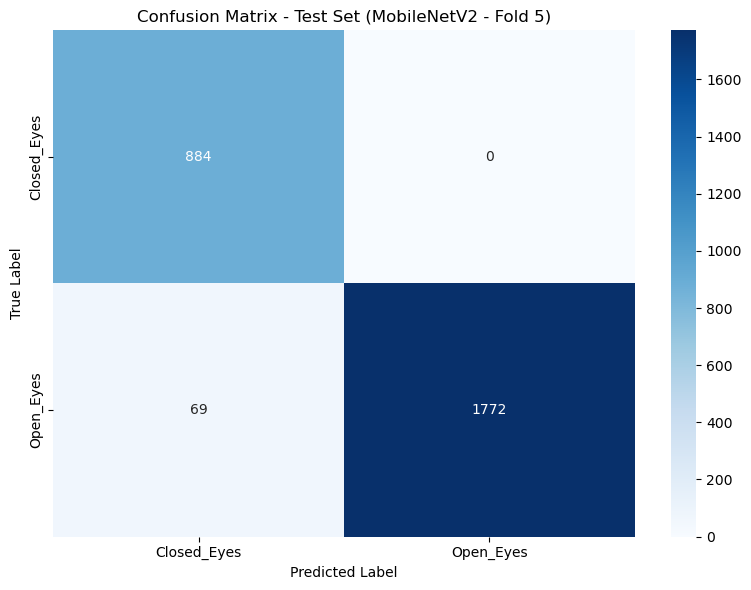

Classification Report (Test Set):
               precision    recall  f1-score   support

 Closed_Eyes       0.93      1.00      0.96       884
   Open_Eyes       1.00      0.96      0.98      1841

    accuracy                           0.97      2725
   macro avg       0.96      0.98      0.97      2725
weighted avg       0.98      0.97      0.97      2725


Final Test Accuracy: 0.9747


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

final_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = final_model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(lbls.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title(f"Confusion Matrix - Test Set (MobileNetV2 - Fold {best_fold})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("../outputs/mobilenet/confusion_matrix_test.png", dpi=300, bbox_inches='tight')
plt.show()

report = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report (Test Set):\n", report)

test_acc = (y_true == y_pred).mean()
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

## Test Sample Predictions Visualization

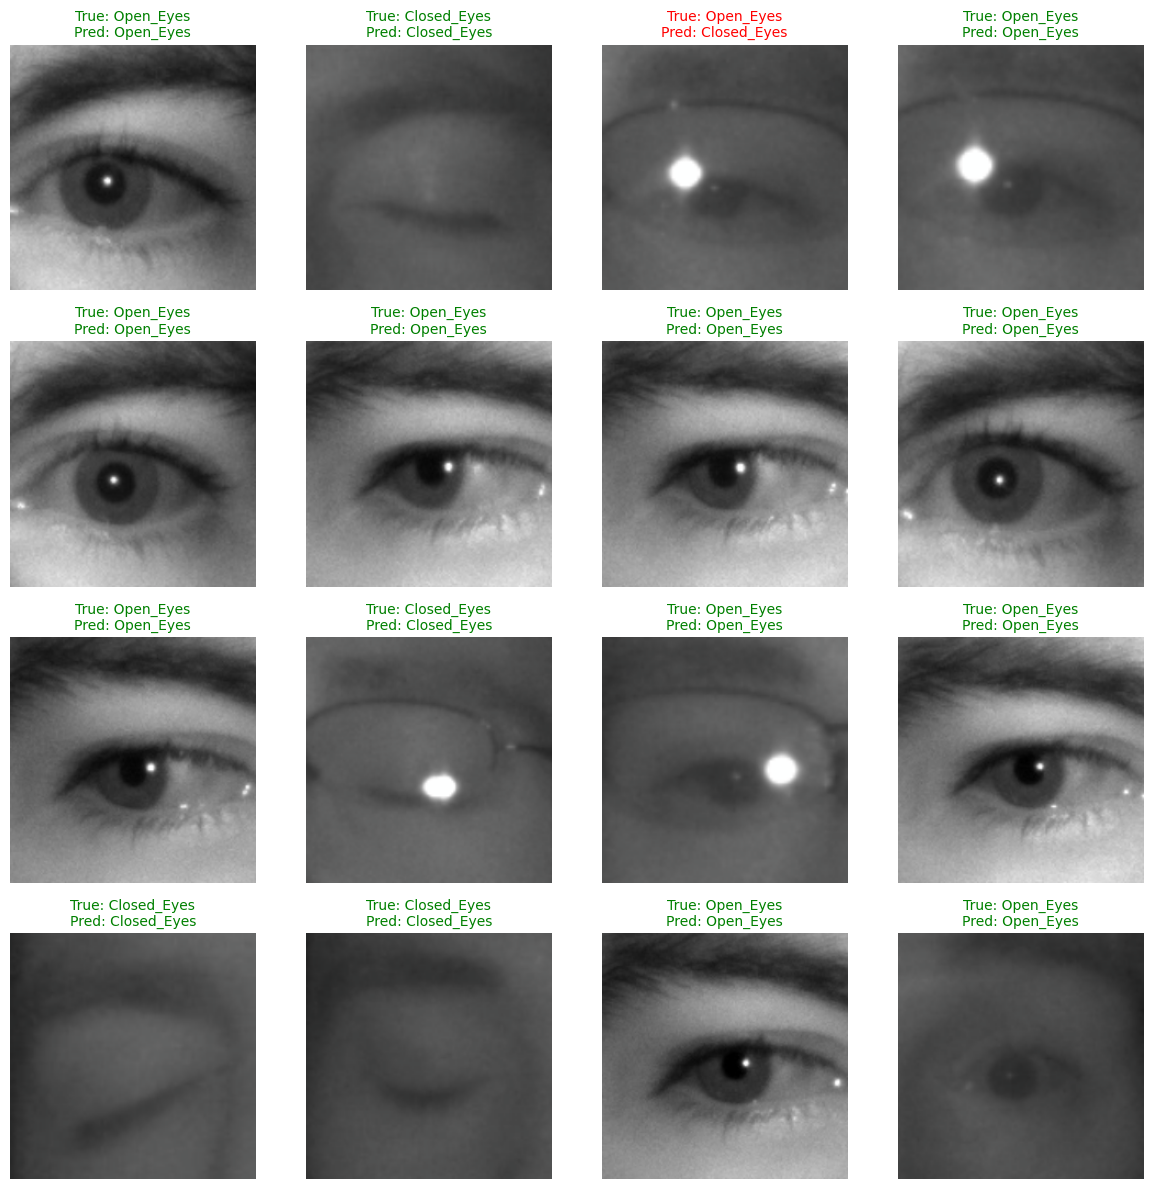

In [ ]:
import random

num_samples = 16
sample_indices = random.sample(range(len(test_dataset)), num_samples)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

final_model.eval()
with torch.no_grad():
    for i, idx in enumerate(sample_indices):
        img, true_label = test_dataset[idx]
        img_input = img.unsqueeze(0).to(device)
        
        output = final_model(img_input)
        pred_label = output.argmax(dim=1).item()
        
        img_display = img.permute(1, 2, 0).cpu().numpy()
        img_display = (img_display * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        img_display = np.clip(img_display, 0, 1)
        
        axes[i].imshow(img_display)
        axes[i].axis('off')
        
        color = 'green' if pred_label == true_label else 'red'
        axes[i].set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}", 
                         color=color, fontsize=10)

plt.tight_layout()
plt.savefig("../outputs/mobilenet/test_predictions_sample.png", dpi=300, bbox_inches='tight')
plt.show()